In [2]:
import pandas as pd
import numpy as np
import sys, os, re, json

import nltk
#from nltk.tokenize import word_tokenize
#from nltk import pos_tag
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import wordnet as wn

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import MultinomialNB #naive_bayes

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
figsize(5, 5)
sns.set()


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [16]:
#pip install torchvision

Note: you may need to restart the kernel to use updated packages.


#### Important Functions

In [3]:
#### Missing Values Analysis

def assess_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the 
    percentage of NA values in each column.    The column names are noted on 
    the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
        # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])  
        # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    return df_NA

In [4]:
def pandas_freq(data,col):
    """
    Creates a frequency table with the percentages for a given column of a pandas dataframe. 
    """
    count = pd.crosstab(index=data[col].astype(str),columns="count").sort_values(by=[col],ascending=False).values
    
    percent = ( ((count / len(data.index))*100).round(4) )
        # concatenate along the columns to create the complete dataframe
    df_freq = pd.concat([pd.DataFrame(count, columns=["Count"]), 
                         pd.DataFrame(percent, columns= ["Percent"])], axis=1) 
    
    
    indexes = data[col].value_counts(normalize=False).index
    df_freq.set_index(indexes, inplace = True,drop = True)
    
    return df_freq

In [5]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))
    disp = plot_confusion_matrix(model, X, y, cmap=plt.cm.PuBuGn, normalize='true')
    plt.savefig(model_name + "_" + label.lower() + ".eps")
    plt.show()
    print()

In [6]:
def evaluate_model(model, model_name="model", y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
    evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
    evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

In [6]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
missing_values = ["n/a", "na", "--", "nan"] # Making a list of missing value types
train = pd.read_csv('CrystalBall_customerReviews_preprocessed.csv', low_memory=False, delimiter =',', na_values = missing_values)

In [41]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6920 non-null   object
 1   label   6920 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [27]:
df.columns = ['text', 'label']

#### Missing Values

In [7]:
assess_NA(train)

,Number of NA,Percent NA
Review_Content_Parsed,78,0.01
reviewText,22,0.00
summary,1,0.00


In [19]:
assess_NA(df)

,Number of NA,Percent NA


In [8]:
missing_indexes = train[train['summary'].isnull()].index.tolist() +train[train['reviewText'].isnull()].index.tolist() + train[train['Review_Content_Parsed'].isnull()].index.tolist()
display(len(missing_indexes))

missing_indexes = list(set(missing_indexes))
(len(missing_indexes))

101

79

#### Those missing values are just a really small fraction of the data so they'll be removed

In [9]:
train = train.drop(train.index[missing_indexes]) #removes the observation where actual y is null
train.shape

(947445, 8)

### Data Distribution

In [22]:
pandas_freq(train,"Rating")

,Count,Percent
5,560232,59.1308
4,244000,25.7535
3,91175,9.6232
2,31025,3.2746
1,21013,2.2179


In [23]:
pandas_freq(train,"std_rating")

,Count,Percent
1.00,560232,59.1308
0.75,244000,25.7535
0.50,91175,9.6232
0.25,31025,3.2746
0.00,21013,2.2179


We're dealing with imbalanced data here.

In [29]:
df.head(5)

,text,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [30]:
pandas_freq(df,"label")

,Count,Percent
1,3610,52.1676
0,3310,47.8324


### Data Preprocessing and Split

We need to seperate training, validation, and testing sets.

* Training set: balanced dataset
* Validation/Testing set: raw (imbalanced) dataset

In [10]:
df_train_raw, df_test = train_test_split(train, test_size=20000, random_state=42, shuffle=True)

df_train_raw, df_dev = train_test_split(df_train_raw, test_size=20000, random_state=42, shuffle=True)

#here we select the test_size as a number close to the count of the lowest class

In [11]:
pandas_freq(df_train_raw,"Rating")

,Count,Percent
5,536518,59.1240
4,233727,25.7566
3,87254,9.6153
2,29782,3.2820
1,20164,2.2221


In [11]:
from sklearn.utils import resample

def undersample(df,col, group_size=20000):
    dfs = []

    for label in df[col].value_counts().keys():
        df_group = df[df[col] == label]
        df_group_undersampled = resample(df_group, 
                                       replace=False, 
                                       n_samples=group_size, 
                                       random_state=42)
        dfs.append(df_group_undersampled)

    return pd.concat(dfs).sample(frac=1, random_state=42)

In [12]:
df_train = undersample(df_train_raw,"Rating")

In [14]:
pandas_freq(df_train,"Rating")

,Count,Percent
1,20000,20.0
2,20000,20.0
3,20000,20.0
4,20000,20.0
5,20000,20.0


In [29]:
pandas_freq(df_dev,"Rating")

,Count,Percent
5,11941,59.705
4,5064,25.320
3,1949,9.745
2,635,3.175
1,411,2.055


In [30]:
pandas_freq(df_test,"Rating")

,Count,Percent
5,11773,58.865
4,5209,26.045
3,1972,9.860
2,608,3.040
1,438,2.190


In [13]:
df_train["num_Review_Content_Parsed"] = df_train["Review_Content_Parsed"].map(len)

<AxesSubplot:xlabel='num_Review_Content_Parsed', ylabel='Density'>

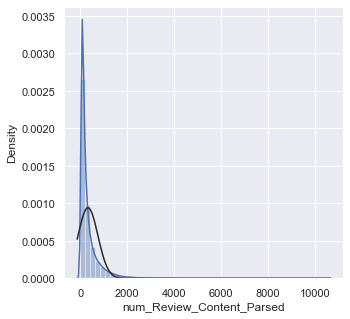

In [16]:
#Check the frequency of tokens per review and compare it with the preprocessed review
figsize(5,5)
sns.set()
from scipy.stats import norm
sns.distplot(df_train["num_Review_Content_Parsed"],fit=norm)

In [17]:
print(len(df_train[df_train["num_Review_Content_Parsed"] <= 800]) / len(df_train["num_Review_Content_Parsed"]))
print(len(df_train[df_train["num_Review_Content_Parsed"] <= 900]) / len(df_train["num_Review_Content_Parsed"]))

0.89691
0.91606


From the result, we can see most reviews are shorter than 900 meaningful tokens.

# Importing pre-trained DistilBERT model and tokenizer


In [14]:
#pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [14]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [15]:
## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Here, we’ll tokenize and process all sentences together as a batch (the notebook processes a smaller group of examples just for resource considerations).

### Tokenization

df_train is a huge dataset so for performance reasons, we'll use only 4,000 sentences from this dataset

In [92]:
sample_df = df_train.groupby('Rating').apply(lambda x: x.sample(frac=0.04))
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4000 entries, (1, 561413) to (5, 32778)
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ProductID                  4000 non-null   object 
 1   Rating                     4000 non-null   int64  
 2   reviewText                 4000 non-null   object 
 3   reviewTime                 4000 non-null   object 
 4   reviewerID                 4000 non-null   object 
 5   summary                    4000 non-null   object 
 6   std_rating                 4000 non-null   float64
 7   Review_Content_Parsed      4000 non-null   object 
 8   num_Review_Content_Parsed  4000 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 484.3+ KB


In [93]:
sample_df = sample_df.reset_index(drop=True)

In [94]:
sample_df.head(2)

,ProductID,Rating,reviewText,reviewTime,reviewerID,summary,std_rating,Review_Content_Parsed,num_Review_Content_Parsed
0,B007R5LPYQ,1,I never thought the day would come for me to s...,23-Jan-2047,A4F0676P8XPVL,YAWN... boring!!!,0.0,never thought come erotica story boring today ...,271
1,B00HRFJTGM,1,"an excuse (not a reason, which has value) to w...",21-Aug-2046,A2MLMVSHMZW9Z8,trash,0.0,excuse reason value write scene write poorly b...,131


In [95]:
pandas_freq(sample_df,"Rating")

,Count,Percent
5,800,20.0
3,800,20.0
1,800,20.0
4,800,20.0
2,800,20.0


In [96]:
sample_df["Rating_adj"] = sample_df["Rating"]-1

In [97]:
pandas_freq(sample_df,"Rating_adj")

,Count,Percent
3,800,20.0
1,800,20.0
4,800,20.0
2,800,20.0
0,800,20.0


In [98]:
sample_df2 = sample_df[["reviewText","Rating_adj"]]

In [99]:
sample_df2.head(3)

,reviewText,Rating_adj
0,I never thought the day would come for me to s...,0
1,"an excuse (not a reason, which has value) to w...",0
2,***SPOILERS INCLUDED***I read the first book i...,0


In [100]:
tokenized = sample_df2["reviewText"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized.head()

0    [101, 1045, 2196, 2245, 1996, 2154, 2052, 2272...
1    [101, 2019, 8016, 1006, 2025, 1037, 3114, 1010...
2    [101, 1008, 1008, 1008, 27594, 2545, 2443, 100...
3    [101, 2044, 3752, 2319, 18162, 9012, 1006, 105...
4    [101, 1045, 2572, 5580, 2023, 2001, 1037, 2489...
Name: reviewText, dtype: object

In [46]:
batch_1 = df[:2000]

tokenized_example = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_example.head()

0    [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1    [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2    [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3    [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4    [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
Name: 0, dtype: object

### Padding

After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [101]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [47]:
max_len = 0
for i in tokenized_example.values:
    if len(i) > max_len:
        max_len = len(i)

padded_example = np.array([i + [0]*(max_len-len(i)) for i in tokenized_example.values])

Our dataset is now in the padded variable, we can view its dimensions below:

In [102]:
np.array(padded).shape

(4000, 2787)

In [85]:
padded

array([[ 101, 2023, 2338, ...,    0,    0,    0],
       [ 101, 9826, 1045, ...,    0,    0,    0],
       [ 101, 1045, 2001, ...,    0,    0,    0],
       ...,
       [ 101, 9413, 5017, ...,    0,    0,    0],
       [ 101, 1045, 5632, ...,    0,    0,    0],
       [ 101, 1045, 2001, ...,    0,    0,    0]])

In [48]:
np.array(padded_example).shape

(2000, 59)

In [49]:
padded_example

array([[  101,  1037, 18385, ...,     0,     0,     0],
       [  101,  4593,  2128, ...,     0,     0,     0],
       [  101,  2027,  3653, ...,     0,     0,     0],
       ...,
       [  101,  2023,  2028, ...,     0,     0,     0],
       [  101,  1999,  1996, ...,     0,     0,     0],
       [  101,  1996,  3185, ...,     0,     0,     0]])

### Masking

If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [103]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(4000, 2787)

In [52]:
attention_mask_example = np.where(padded_example != 0, 1, 0)
attention_mask_example.shape

(2000, 59)

### Model #1: And Now, Deep Learning!

Now that we have our model and inputs ready, let's run our model!

In [105]:
padded.shape

(4000, 2787)

In [106]:
attention_mask.shape

torch.Size([4000, 2787])

In [107]:
print(torch.max(torch.tensor(padded)))

tensor(29609, dtype=torch.int32)


In [104]:
import torch

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

IndexError: index out of range in self

In [53]:
import torch

input_ids = torch.tensor(padded_example)  
attention_mask = torch.tensor(attention_mask_example)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.


In [57]:
input_ids.shape

torch.Size([2000, 59])

In [56]:
attention_mask_example.shape

(2000, 59)

We'll save those in the features variable, as they'll serve as the features to our logitics regression model.

In [61]:
features = last_hidden_states[0][:,0,:].numpy()

The labels indicating which sentence is positive and negative now go into the labels variable

In [62]:
labels = batch_1[1]

# Model #2: Train/Test 

Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

In [63]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

### [Bonus] Grid Search for Parameters

We can dive into Logistic regression directly with the Scikit Learn default parameters, but sometimes it's worth searching for the best value of the C parameter, which determines regularization strength.

In [ ]:
# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters)
# grid_search.fit(train_features, train_labels)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)


We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the value of C into the model declaration (e.g. LogisticRegression(C=5.2)).

In [64]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

# Evaluating Model #2
So how well does our model do in classifying sentences? One way is to check the accuracy against the testing dataset:

In [65]:
lr_clf.score(test_features, test_labels)

0.812